In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors


In [2]:
# Load dataset
file_path = "/content/career_recommender.csv"
df = pd.read_csv(file_path)

# Trim column names to remove extra spaces
df.columns = df.columns.str.strip()

# Fill missing values with empty strings
df["What are your interests?"] = df["What are your interests?"].fillna("")
df["What are your skills ? (Select multiple if necessary)"] = df["What are your skills ? (Select multiple if necessary)"].fillna("")

# Combine Interests & Skills into a single text column
df["combined_text"] = df["What are your interests?"] + " " + df["What are your skills ? (Select multiple if necessary)"]


In [3]:
# Apply TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words="english", max_features=500)
combined_tfidf = vectorizer.fit_transform(df["combined_text"])

# Convert TF-IDF matrix to DataFrame
combined_df = pd.DataFrame(combined_tfidf.toarray(), columns=vectorizer.get_feature_names_out())


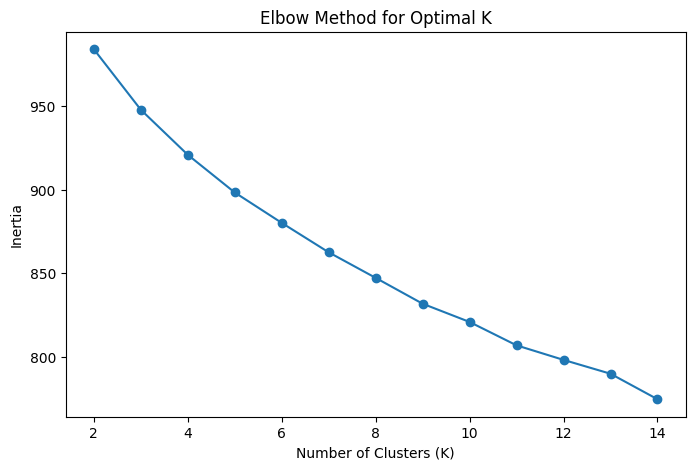

In [4]:
inertia = []
K_range = range(2, 15)  # Testing cluster sizes from 2 to 14

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(combined_df)
    inertia.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker="o", linestyle="-")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()


In [5]:
optimal_k = 6  # Choose K based on the elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(combined_df)


In [6]:
# Standardize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(combined_df)

# Train Nearest Neighbors model for recommendations
nn_model = NearestNeighbors(n_neighbors=5, metric="cosine")
nn_model.fit(scaled_data)

def recommend_careers(input_text):
    """Recommend careers based on user input skills & interests."""
    input_vector = vectorizer.transform([input_text]).toarray()
    input_vector_scaled = scaler.transform(input_vector)

    distances, indices = nn_model.kneighbors(input_vector_scaled)
    recommended_careers = df.iloc[indices[0]]["Cluster"].values

    return recommended_careers

# Example Usage
user_input = "Data Science, Machine Learning, Python"
recommendations = recommend_careers(user_input)
print("Recommended Career Clusters:", recommendations)


Recommended Career Clusters: [0 5 0 5 5]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [7]:
from flask import Flask, request, jsonify

app = Flask(__name__)

@app.route("/recommend", methods=["POST"])
def recommend():
    data = request.json
    user_input = data.get("text", "")
    recommended_careers = recommend_careers(user_input)

    return jsonify({"recommendations": recommended_careers.tolist()})
if __name__ == "__main__":
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [10]:
import pandas as pd

file_path = "career_recommender.csv"
df = pd.read_csv(file_path)

print(df.columns)


Index(['What is your name?', 'What is your gender?',
       'What was your course in UG?',
       'What is your UG specialization? Major Subject (Eg; Mathematics)',
       'What are your interests?',
       'What are your skills ? (Select multiple if necessary)',
       'What was the average CGPA or Percentage obtained in under graduation?',
       'Did you do any certification courses additionally?',
       'If yes, please specify your certificate course title.',
       'Are you working?',
       'If yes, then what is/was your first Job title in your current field of work? If not applicable, write NA.               ',
       'Have you done masters after undergraduation? If yes, mention your field of masters.(Eg; Masters in Mathematics)'],
      dtype='object')


In [11]:
import tkinter as tk
from tkinter import messagebox
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

# Load dataset
file_path = "career_recommender.csv"  # Ensure the file is in the same directory
df = pd.read_csv(file_path)

# Trim column names to remove extra spaces
df.columns = df.columns.str.strip()

# Print all column names to help identify the correct one
print("Dataset Columns:", df.columns)

# Automatically find a column that likely contains career names
possible_career_cols = [col for col in df.columns if "career" in col.lower() or "profession" in col.lower()]
if possible_career_cols:
    career_column = possible_career_cols[0]  # Choose the first matching column
else:
    raise KeyError("Could not find a career-related column. Please check your dataset.")

# Fill missing values
df.fillna("", inplace=True)

# Combine Interests & Skills for processing
df["combined_text"] = df[df.columns[1]] + " " + df[df.columns[2]]  # Assuming 2nd and 3rd columns are interests/skills

# Apply TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words="english", max_features=500)
combined_tfidf = vectorizer.fit_transform(df["combined_text"])
combined_df = pd.DataFrame(combined_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

# Train K-Means for clustering
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(combined_df)

# Standardize data for recommendation
scaler = StandardScaler()
scaled_data = scaler.fit_transform(combined_df)

# Train Nearest Neighbors for recommendation
nn_model = NearestNeighbors(n_neighbors=5, metric="cosine")
nn_model.fit(scaled_data)

def recommend_careers(user_input):
    """Recommend careers based on user input."""
    input_vector = vectorizer.transform([user_input]).toarray()
    input_vector_scaled = scaler.transform(input_vector)

    distances, indices = nn_model.kneighbors(input_vector_scaled)
    recommended_careers = df.iloc[indices[0]][career_column].values

    return recommended_careers

# GUI Function
def get_recommendation():
    user_input = entry.get()
    if not user_input.strip():
        messagebox.showerror("Error", "Please enter your interests and skills!")
        return

    recommendations = recommend_careers(user_input)
    result_text = "\n".join([f"{i+1}. {career}" for i, career in enumerate(recommendations)])

    messagebox.showinfo("Recommended Careers", f"Suggested Careers:\n{result_text}")

# Create GUI Window
app = tk.Tk()
app.title("Career Recommendation System")
app.geometry("500x300")

tk.Label(app, text="Enter Your Interests & Skills:", font=("Arial", 12)).pack(pady=10)
entry = tk.Entry(app, width=50)
entry.pack(pady=5)

recommend_btn = tk.Button(app, text="Get Career Recommendation", command=get_recommendation)
recommend_btn.pack(pady=20)

app.mainloop()


Dataset Columns: Index(['What is your name?', 'What is your gender?',
       'What was your course in UG?',
       'What is your UG specialization? Major Subject (Eg; Mathematics)',
       'What are your interests?',
       'What are your skills ? (Select multiple if necessary)',
       'What was the average CGPA or Percentage obtained in under graduation?',
       'Did you do any certification courses additionally?',
       'If yes, please specify your certificate course title.',
       'Are you working?',
       'If yes, then what is/was your first Job title in your current field of work? If not applicable, write NA.',
       'Have you done masters after undergraduation? If yes, mention your field of masters.(Eg; Masters in Mathematics)'],
      dtype='object')


KeyError: 'Could not find a career-related column. Please check your dataset.'